In [38]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Normalizer

from numpy.linalg import norm

from utility_funcs import *

import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

- В склерне оптимальные параметры ядра ищутся не градиентным спуском, а в gpytorch градиентным спуском как внутри pytorch - в этом главное отличие 

- Лосс, который пишется у гпр - это -log likelyhood loss для параметров, которые мы обучаем

- Мы добавляем какие-то параметры, чтобы не делать операции $O(N^3)$, а сделать несколько шагов оптимизации параметров вместе того, чтобы полностью точно считать обратную к K

- в склерне дефолтный кернел - это конст кернел * RBF - короче там 2 параметра обучается

In [39]:
MODE

'movements'

In [40]:
def make_predictions_and_check_quality(model, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=nn.MSELoss(), data=None, same_axis=False):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    Качество

    '''

    if data:
        X_matrices, Y_target, *_ = list(map(lambda x: torch.stack(x), list(zip(*data))))

        
    Y_pred = model.predict(X_matrices)
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]
    metric = mean_squared_error(Y_pred, Y_target)

    print(metric)

    return Ys

In [41]:
def formate_data_for_sklearn(data, size_cut=1):

    X = [elem[0].detach().numpy() for elem in data[:len(data) * size_cut]]
    Y = [elem[1].detach().numpy() for elem in data[:len(data) * size_cut]]

    X = np.stack(X)
    Y = np.stack(Y)
    return X, Y

In [42]:
my_kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")  # пока фиксированные параметры

# my_kernel = ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) * RBF(1., length_scale_bounds=(1e-5, 1e5))

my_kernel

1**2 * RBF(length_scale=1)

In [43]:
data = torch.load(path)

In [44]:
train_data, val_data, *_ = recieve_loaders(
    path=path,
    # take_one_projection_for_data=0,

    # normalize_X=True,
    # scale_y=True
)       # in sklearn it is not learning in batches, so batch_size is not needed here

tensor([1.8426e-04, 2.2059e-04, 1.4002e-05])
(tensor([ 0.0870,  0.0000,  0.0000,  0.0000,  0.0308,  0.0000,  0.0000,  0.0000,
         0.0088,  0.1836,  0.2198, -0.0140]), tensor([1.8426e-04, 2.2059e-04, 1.4002e-05]), tensor([[ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0., -1.]]), tensor([ 1.8426e-04,  2.2059e-04, -1.4002e-05]))


In [45]:
train_X, train_Y = formate_data_for_sklearn(train_data)
val_X, val_Y = formate_data_for_sklearn(val_data)

In [46]:
# normer = Normalizer()
# train_X = normer.fit_transform(train_X)
# val_X = normer.transform(val_X)

n_restarts_optimizer - если вдруг может быть несколько оптимумов чтобы несколько раз запустилось и попрбовало найти типо их несколько раз

- Что вообще оптимизируется - поскольку единственная случайно выбранная нами здесь вещь - это функция ядра, то мы как раз и оптимизируем параметры внутри этой функции ядра так, чтобы
мы получали ответы максимально близкие к таргетам. Она оптммизируется путем максимизации минус логарифма правдоподобия для данного параметра при условии данных

In [47]:
from sklearn.ensemble import RandomForestRegressor
import catboost

In [48]:
model = GaussianProcessRegressor(
    kernel=my_kernel,
    random_state=0,
    n_restarts_optimizer=1,
    # normalize_y=True
    )

model.fit(train_X, train_Y)

Y_pred = model.predict(val_X, return_std=False)

In [49]:
# model = catboost.CatBoostRegressor(loss_function="MultiRMSE")
# model.fit(train_X, train_Y)
# Y_pred = model.predict(val_X)

In [50]:
# model = RandomForestRegressor(n_jobs=-1)
# model.fit(train_X, train_Y)
# Y_pred = model.predict(val_X)

In [51]:
mean_squared_error(val_Y, Y_pred)

9.1663680448722e-11

In [52]:
model.score(val_X, val_Y)

0.9986081228790137

In [53]:
try: 
    make_predictions_and_check_quality(model=model, data=val_data, same_axis=False)
except:
    pass
None

9.1663680448722e-11


---
Снизу попытки что-то визуализировать:

In [54]:
x11_val = val_X[:, 0]
x22_val = val_X[:, 4]
x33_val = val_X[:, 8]

In [55]:
Y_pred = model.predict(val_X)

In [56]:
# plot_2d_result(
#     x11_val,
#     y_true=Y_true if len(train_data[0][1]) == 1 else [elem[0] for elem in Y_true],
#     y_pred=Y_pred if len(train_data[0][1]) == 1 else [elem[0] for elem in Y_pred],
#     figsize=(20, 10)
# )

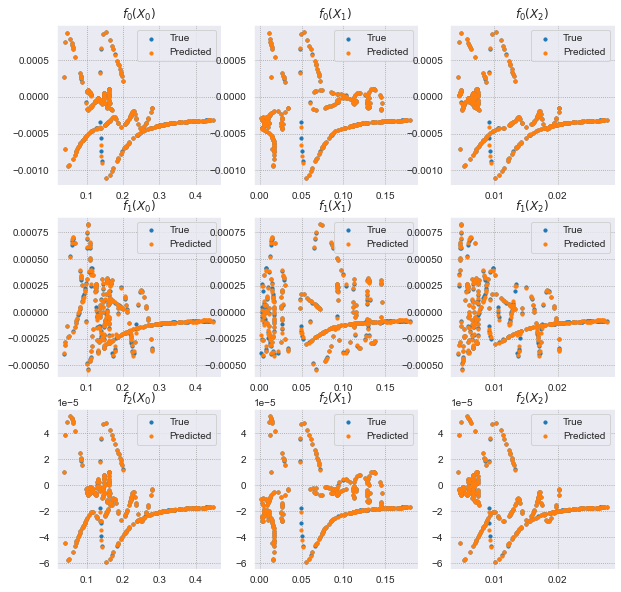

In [57]:
if len(train_data[0][1]) != 1:
    plot_matrix(
        X=[elem[:-3] for elem in val_X] if MODE == "movements" else val_X,
        K=CFG.K,
        Y_true=val_Y,
        Y_pred=Y_pred,

        figsize=(10, 10)
    )

---
# Модель для скоростей:

In [58]:
# path_vel = './dataset_objects/' + "d_velocities" + '/3_dataset_K_3.pt'        # ЗДЕСЬ БЫЛО МОДЕ ВМЕСТО movements

In [59]:
data_vel = torch.load(path_vel)

In [73]:
train_data_vel, val_data_vel, _, _, Descaler = recieve_loaders(
    path=path_vel,
    # take_one_projection_for_data=0,

    # normalize_X=True,
    # scale_y=True
)       # in sklearn it is not learning in batches, so batch_size is not needed here

tensor([1.3001e-03, 1.5679e-03, 9.8292e-05])
(tensor([ 0.0870,  0.0000,  0.0000,  0.0000,  0.0308,  0.0000,  0.0000,  0.0000,
         0.0088,  0.1836,  0.2198, -0.0140]), tensor([1.3001e-03, 1.5679e-03, 9.8292e-05]), tensor([[ 1.,  0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0., -1.]]), tensor([ 1.3001e-03,  1.5679e-03, -9.8292e-05]))


In [61]:
train_X_vel, train_Y_vel = formate_data_for_sklearn(train_data_vel)
val_X_vel, val_Y_vel = formate_data_for_sklearn(val_data_vel)

In [62]:
model_vel = GaussianProcessRegressor(
    kernel=my_kernel,
    random_state=0,
    n_restarts_optimizer=1,
    # normalize_y=True
    )

model_vel.fit(train_X_vel, train_Y_vel)

Y_pred_vel = model_vel.predict(val_X_vel, return_std=False)

In [63]:
mean_squared_error(val_Y_vel, Y_pred_vel)

2.2851630904106084e-07

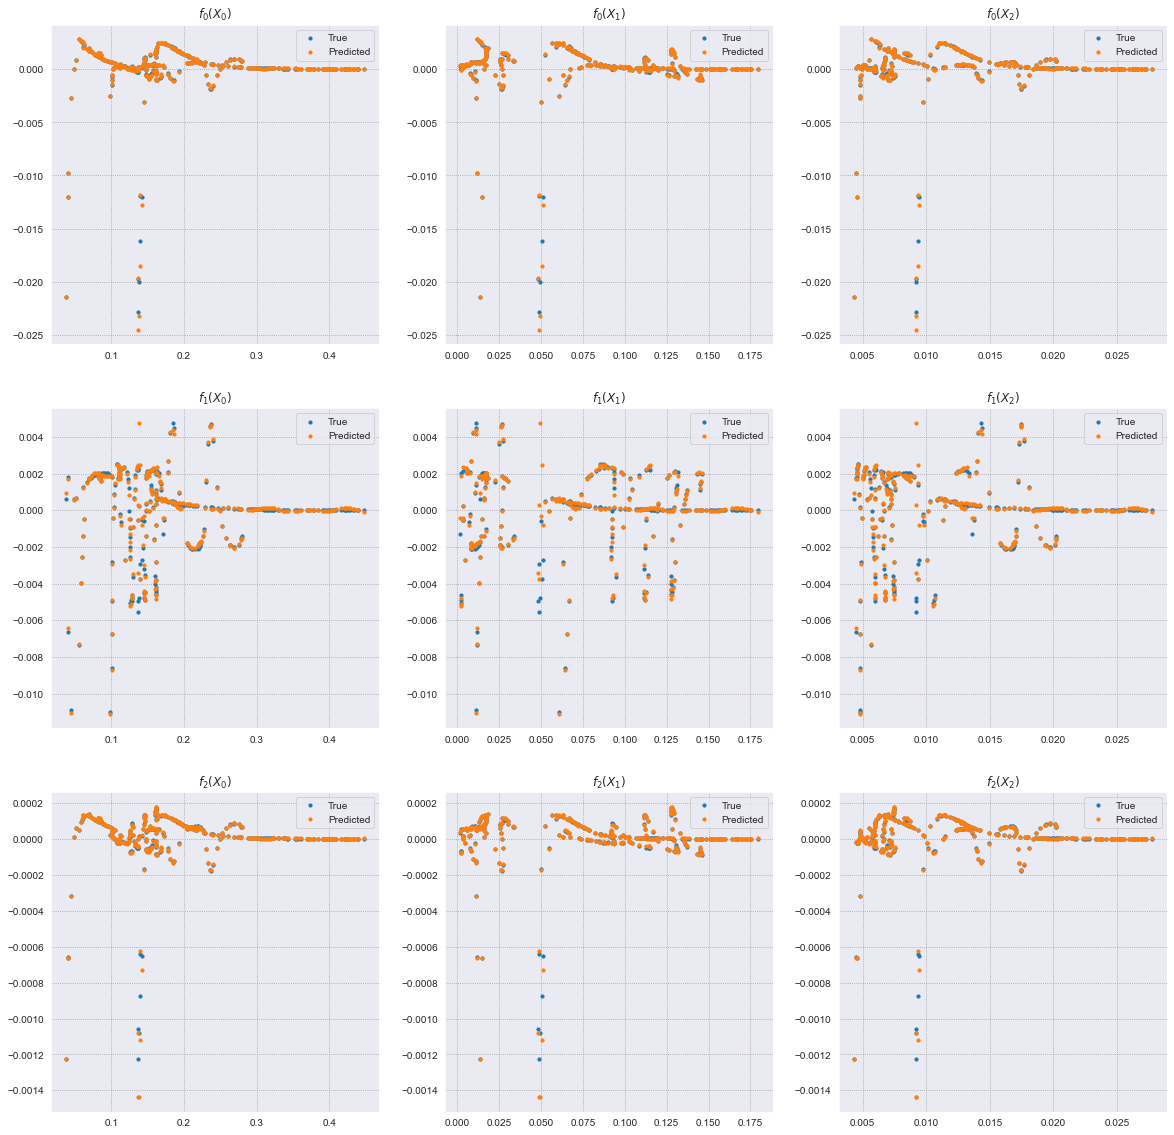

In [64]:
if len(train_data[0][1]) != 1:
    plot_matrix(
        X=[elem[:-3] for elem in val_X_vel] if MODE == "movements" else val_X_vel,
        K=CFG.K,
        Y_true=val_Y_vel,
        Y_pred=Y_pred_vel,

        figsize=(20, 20)
    )

In [65]:
import dill

In [66]:
model_file_path = f'./trained_models/gpr_{CFG.N}_movements_K{CFG.K}.pickle'
model_vel_file_path = f'./trained_models/gpr_{CFG.N}_velocities_K{CFG.K}.pickle'

In [67]:
pickle_mov = open(model_file_path, 'wb')
dill.dump(model, pickle_mov)
pickle_mov.close()

In [68]:
pickle_vel = open(model_vel_file_path, 'wb')
dill.dump(model_vel, pickle_vel)
pickle_vel.close()

---
---
---

## Для реальных сил визуализация + сравнение с Верле:

Чтобы отрисовать Верле на том же графике надо взять проекцию $vdt + (F / 2 )dt^2$ в проекции на V_i

In [69]:
t = val_data[0]

In [70]:
Y_true_3d = [elem[3] for elem in val_data]

In [71]:
Y_true_3d

[tensor([-7.3501e-04, -8.5931e-05,  4.3292e-05]),
 tensor([ 3.8479e-04, -1.0821e-04, -2.0341e-05]),
 tensor([-3.3811e-04, -2.5851e-05,  1.9650e-05]),
 tensor([-2.4085e-04,  2.6768e-04,  9.7411e-06]),
 tensor([-1.4544e-04, -3.2519e-04,  1.3139e-05]),
 tensor([ 3.2261e-04, -8.3369e-05, -1.7153e-05]),
 tensor([-1.5693e-04,  3.4156e-04,  3.8610e-06]),
 tensor([-3.7898e-04,  5.3662e-05,  2.1080e-05]),
 tensor([ 6.4407e-04, -1.8463e-04, -3.4051e-05]),
 tensor([ 4.5570e-05,  1.4945e-04, -4.8037e-06]),
 tensor([-5.2443e-05,  2.2924e-05,  2.6665e-06]),
 tensor([-1.1850e-04,  3.1971e-04,  2.0287e-06]),
 tensor([-3.9519e-05,  1.3516e-04,  2.5997e-07]),
 tensor([-7.7447e-04,  1.3524e-04,  4.2578e-05]),
 tensor([-6.9939e-04,  1.1650e-04,  3.8546e-05]),
 tensor([ 3.2832e-04, -8.5960e-05, -1.7441e-05]),
 tensor([ 3.7541e-04, -1.0488e-04, -1.9854e-05]),
 tensor([ 2.9512e-05, -3.5990e-04,  3.7040e-06]),
 tensor([ 4.2283e-04, -1.2067e-04, -2.2333e-05]),
 tensor([-7.6454e-05, -9.6312e-05,  5.8013e-06]),


In [72]:
def s_by_verlet(X, dt):
    '''
    
    '''